To run this example notebook:
* pandas, numy, biopython are needed for this notebook.
* bacteria model files and lshvec java library are required to be downloaded (refer to project README)
* install PyLSHVec (pip, docker or from code)
* Be warning that jnius may not work on your environment. Refer to https://github.com/kivy/pyjnius for trouble shooting.

To make this notebok easier, it does not use multiple therads for prediction. However it also makes the notebook slow.

In [1]:
%pylab inline
import sys,os
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
if 0: #dirty fix
    sys.path.insert(0,"../src/")
    os.environ['JAVA_HOME']='/usr/lib/jvm/java-openjdk/'

In [5]:
from pylshvec import *

In [6]:
#here needs jlshvec jar file, download it first
set_lshvec_jar_path("/mnt/jlshvec-assembly-0.1.jar")

In [7]:
#since vector model is usually large, set a big java memory limit is preferred. 
add_java_options("-Xmx32G")

In [8]:
#here need model file and lsh function file, download them first
model= LSHVec(model_file="/mnt/refdb_bacteria_model_gs_k23_l3000_rand_m299", hash_file="/mnt/lsh_nt_NonEukaryota_k23_h25.crp")

In [9]:
#use help to see the methods
help(model)

Help on LSHVec in module pylshvec.lshvec object:

class LSHVec(builtins.object)
 |  LSHVec(model_file, hash_file, threshold=0.005, max_results=500, batch_size=1024, num_thread=1, only_show_main_tax=False, without_uncult=True)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_file, hash_file, threshold=0.005, max_results=500, batch_size=1024, num_thread=1, only_show_main_tax=False, without_uncult=True)
 |      load a pre-trained lshvec model. 
 |      
 |      Parameters:
 |          model_file: pre-trained model file, which contains k-mer vectors and model parameters
 |          hash_file: lsh hash function file
 |      
 |      Refer to get methods for the meaning of other parameters
 |  
 |  embedding(self, seq_or_seqs)
 |      Get the embedding vector/vectors for a sequence or a list of sequence (multiple threads if #thread > 1)
 |  
 |  embedding_single_thread(self, seq_or_seqs)
 |      Get the embedding vector/vectors for a sequence or a list of sequence (single thread 

In [10]:
#To show some parameters
getIgnores = ['getRank', 'getName', 'getTaxIdPath', 'getTaxNamePath']
for u in dir(model):
    if not u in getIgnores:
        if u.startswith('get') or u.startswith('is'):
            fun = getattr(model, u)
            print(u, fun())

getBatchsize 1024
getKmerSize 23
getMaxItems 500
getNumThread 1
getThreshold 0.004999999888241291
getVecDim 100
isInitialized True
isOnlyShowLeaf False
isOnlyShowMainTax True
isWithoutUncult True


In [11]:
#to show information for a taxonomy id
# All taxonomiy ids are ncbi taxonomy ids, except dummy id which is not less than 4000000
for u in getIgnores:
    fun = getattr(model, u)
    print(u, fun(350703))

getRank no rank
getName Pseudomonas aeruginosa 2192
getTaxIdPath [1, 131567, 2, 4000000, 4000002, 4000005, 4000467, 1224, 4000609, 4002543, 4010383, 1236, 4107259, 4124163, 4159985, 4165920, 72274, 4165922, 135621, 4165925, 4166101, 4166121, 286, 4166128, 4166131, 4166192, 4166194, 4166196, 4166199, 4166200, 136841, 4166202, 4166205, 4166211, 287, 4166212, 4166215, 4166351, 4166407, 4166435, 4166448, 4166451, 4166455]
getTaxNamePath ['root', 'cellular organisms', 'Bacteria', 'dummy4000000', 'dummy4000002', 'dummy4000005', 'dummy4000467', 'Proteobacteria', 'dummy4000609', 'dummy4002543', 'dummy4010383', 'Gammaproteobacteria', 'dummy4107259', 'dummy4124163', 'dummy4159985', 'dummy4165920', 'Pseudomonadales', 'dummy4165922', 'Pseudomonadaceae', 'dummy4165925', 'dummy4166101', 'dummy4166121', 'Pseudomonas', 'dummy4166128', 'dummy4166131', 'dummy4166192', 'dummy4166194', 'dummy4166196', 'dummy4166199', 'dummy4166200', 'Pseudomonas aeruginosa group', 'dummy4166202', 'dummy4166205', 'dummy416

In [12]:
def random_dna_sequence(length):
    return ''.join(np.random.choice(list('ACTG')) for _ in range(length))

def add_substitute_error(seq, err_rate=0.05):
    return "".join(    np.random.choice(list('ACTG'))  if np.random.random()<err_rate else u for u in seq )
def random_sub_seq(seq,length=500):
    assert len(seq)>length
    i=int(np.random.random()*(len(seq)-length))
    return seq[i:i+length]
def predict(seq):
    pred=pd.Series(model.predict(seq), name='prob')
    pred.index.name='taxid'
    pred=pred.to_frame()
    pred['rank']=pred.index.map(lambda u: model.getRank(u))
    pred['name']=pred.index.map(lambda u: model.getName(u))
    return pred.sort_values("prob",ascending=False)

### let's play with an assembly  for (Pseudomonas aeruginosa)[https://www.ncbi.nlm.nih.gov/assembly/GCF_000152545.1/] whose taxid is 350703.

In [13]:
url="ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/152/545/GCA_000152545.1_ASM15254v1/GCA_000152545.1_ASM15254v1_genomic.fna.gz"

In [14]:
#download the sequence
import urllib 
from Bio import SeqIO
import gzip
with  urllib.request.urlopen(url) as handle_url :
    with gzip.open(handle_url, 'rt') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            print(record.id, len(record))
            break

CH482384.1 6905121


In [15]:
seq=str(record.seq)
print ("The sequence length is {}".format(len(seq)))
print ("The sequence is a bit long. To save time, we only keep 50K of it")
seq=seq[2000000:2000000+50000]
print ("Sampled sequence length is {}".format(len(seq)))

The sequence length is 6905121
The sequence is a bit long. To save time, we only keep 50K of it
Sampled sequence length is 50000


##### Look at how the model predict on the  seq. Note that we only make predictions on main ranks. (actually it does not work good on strain level)

In [17]:
predict(seq)

,prob,rank,name
taxid,,,
2,1.0000,superkingdom,Bacteria
1224,0.9977,phylum,Proteobacteria
1236,0.9958,class,Gammaproteobacteria
135621,0.9951,family,Pseudomonadaceae
72274,0.9950,order,Pseudomonadales
286,0.9950,genus,Pseudomonas
287,0.9864,species,Pseudomonas aeruginosa


### While, it gives a probability of 0.96 on species 287, which is good. 

### How about introducing errors? I only randomly introduce substituting errors in this notebook (More realistic errors untilize error profile/distribution which is too complex here.).  For example for err rate 3%, the probabily for 287 becomes 80+%.

In [18]:
predict(add_substitute_error(seq,0.03)).head(15)

,prob,rank,name
taxid,,,
2,1.0000,superkingdom,Bacteria
1224,0.9805,phylum,Proteobacteria
1236,0.9620,class,Gammaproteobacteria
72274,0.9539,order,Pseudomonadales
135621,0.9539,family,Pseudomonadaceae
286,0.9533,genus,Pseudomonas
287,0.8779,species,Pseudomonas aeruginosa
201174,0.0179,phylum,Actinobacteria
1760,0.0178,class,Actinobacteria


### Let's do 20 times for each error rate and show the accuracy of correctly predicting 287

In [19]:
def mean_prob_with_error(seq, error_rate=0.01, target_taxid=287):
    count=0.0
    for i in range(20):
        pred = predict(add_substitute_error(seq, error_rate))
        species_pred_df = pred[pred['rank']=="species"]
        if(len(species_pred_df)==0):
            pass
        else:
            
            taxid= species_pred_df.iloc[0].name
            if target_taxid ==taxid:
                count+=1
            else:
                pass
    return count/20


In [20]:
err_rates =np.arange(0.01,0.10,0.01)
acc=[mean_prob_with_error(seq,x) for x in err_rates]

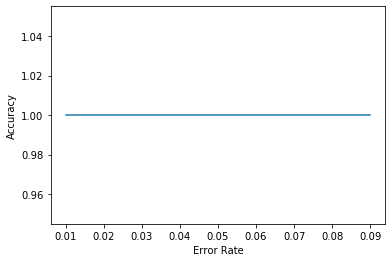

In [21]:
plt.plot(err_rates,acc)
plt.xlabel("Error Rate")
plt.ylabel("Accuracy");

### While, seems that the seq is still a bit long. Let's do with a 1000-length seq and increase error rate to 20%.

In [28]:
err_rates =np.arange(0.01,0.20,0.01)
acc=[mean_prob_with_error(seq[:1000],x) for x in err_rates]

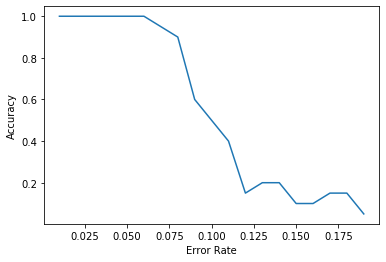

In [29]:
plt.plot(err_rates,acc)
plt.xlabel("Error Rate")
plt.ylabel("Accuracy");

### All the above work on the whole sequence. How about for sub sequences?

In [30]:
predict(random_sub_seq(seq,300))

,prob,rank,name
taxid,,,
2,1.0000,superkingdom,Bacteria
1224,0.9863,phylum,Proteobacteria
1236,0.9798,class,Gammaproteobacteria
135621,0.9745,family,Pseudomonadaceae
72274,0.9744,order,Pseudomonadales
286,0.9742,genus,Pseudomonas
287,0.9097,species,Pseudomonas aeruginosa
201174,0.0129,phylum,Actinobacteria
1760,0.0128,class,Actinobacteria


### It is not bad for a 300-length sequence.

### We are going to show the mean prediction probabilities for tax 1980526 for various subseq length.

In [32]:
def mean_prob(seq_len=500, target_taxid=287):
    prob_list=[]
    for i in range(0,len(seq)-seq_len,int(seq_len/2)):
        aseq = seq[i:i+seq_len]
        pred = model.predict(aseq)
        if target_taxid in pred:
            prob_list.append(pred[target_taxid])
        else:
            prob_list.append(0)
    return np.mean(prob_list)


In [33]:
lengths =list( range(100,500,25))
probs=[mean_prob(seq_len=u) for u in lengths]

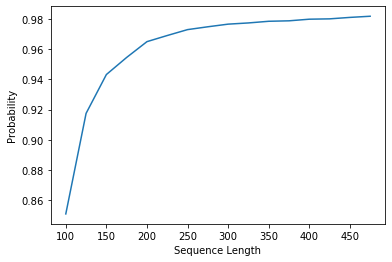

In [34]:
plt.plot(lengths,probs)
plt.ylabel("Probability")
plt.xlabel("Sequence Length");